In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors

from itertools import combinations, permutations
import scipy
from scipy.ndimage.filters import gaussian_filter1d
import sys
import os
import copy
atish_assay_path = 'fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()
from tools import mutant_colorset

In [4]:
merged_name = 'noF_DoubleBC_merged+flaskswapcorrected_052019' 
unmerged_name = 'noF_DoubleBC_flaskswapcorrected_052019'

merged_data = p.read_csv(f'../data/BarcodeCounts_{merged_name}_withBCinfo.csv')
unmerged_data = p.read_csv(f'../data/BarcodeCounts_{unmerged_name}_withBCinfo.csv')

bad_samples = ['B.DE1.PCRb.3']

cov_thresh = 1e6

In [6]:
# data
no_digest_conditions = ['A0-DE2-PCRa',
'A4-DE1-PCRb',
'B2-DE1-PCRc',
'C0-DE1-PCRc',
'D1-DE1-PCRb',
'E0-DE2-PCRa',
'E4-DE1-PCRb',
'F3-DE1-PCRb',
'A1-DE1-PCRb',
'B3-DE1-PCRc',
# 'C2-DE3-PCRb', # this is a 27 cycle bubble product sample
'D2-DE1-PCRb',
'E1-DE2-PCRa',
'F0-DE2-PCRa',
'F4-DE1-PCRb',
'Tneg-DE3-PCRa',
'A2-DE1-PCRb',
'B1-DE2-PCRa',
'B4-DE5-PCRa',
'C2-DE3-PCRa',
'C3-DE2-PCRa',
'D3-DE1-PCRb',
'E2-DE1-PCRb',
'F1-DE1-PCRb',
'A3-DE1-PCRb',
'C1-DE1-PCRc',
'C4-DE3-PCRa',
# 'C4-DE3-PCRb', # this is a 27 cycle bubble product sample
'D0-DE2-PCRa',
'D4-DE1-PCRb',
'E3-DE1-PCRb',
'F2-DE1-PCRb']

reps = ['A','B','C','D']

anc_data = unmerged_data
anc_data = anc_data.replace([np.inf, -np.inf], np.nan)
anc_data = anc_data.sort_values('barcode')

counted_anc = {}
counted_anc_times = {}

for rep in reps:
    
    timepoints = range(5)
    accepted_times = []
    for t in timepoints:
        for col in no_digest_conditions:
            if col.split('-')[0] == f'{rep}{t}':
                accepted_times.append(t)

    these_times = ['Tneg-DE3-PCRa'] + [col for t in timepoints for col in no_digest_conditions if col.split('-')[0] == f'{rep}{t}']
    
    
    
    these_counts = anc_data[these_times].values
    these_freqs = these_counts/np.sum(these_counts,axis=0)
#     print(len(these_freqs[-1,:]))
#     print(len(accepted_times))
    
    counted_anc[rep] = these_freqs[-1,:]
    counted_anc_times[rep] = [-1]+accepted_times
    
    print(len(counted_anc[rep] ))
    print(len(counted_anc_times[rep] ))

6
6
5
5
6
6
6
6


In [56]:
data = merged_data
data = data[~(data['barcode'].isin([7777777,9999999]))]
data = data.replace([np.inf, -np.inf], np.nan)
data = data.sort_values('barcode')

full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))
neutrals = [bc for bc in neutrals if bc in data['barcode'].values]
neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]

mean_fitness = {}
fitness = {}

counting_variance = {}

reps = ['A','B','C','D']

for rep in reps:
    timepoints = range(5)
    these_times = [f'{rep}{t}' for t in timepoints]
    answer = atish.inferFitness(data['barcode'].values,timepoints,{'rep1':data[these_times].values},neutralBarcodes=neutrals,
                                                lowCoverageThresh=cov_thresh,use_all_neutral=True,weightedMean=False)
    
    mean_fitness[rep] = answer['rep1']['meanFitness']
    fitness[rep] = answer['rep1']['allTimeFitness']
    counting_variance[rep] = (np.exp(-1*np.log10(np.sum(data[these_times].values,axis=0))-1)*np.power(data[these_times].values,-1))[:,:-1]
    
bc_fraction = {}
for rep in reps:
    timepoints = range(5)
    these_times = ['Tneg'] + [f'{rep}{t}' for t in timepoints]
    this_data = data[these_times].values
    
    these_freqs = this_data/np.sum(this_data,axis=0)
    neutral_freqs = np.sum(these_freqs[neutral_locs,:],axis=0)
    
    initial_frac = 0.1
    
    q = neutral_freqs[0]*initial_frac/(1-initial_frac)
    
#     neutral_frac = np.sum(this_data[neutral_locs,:],axis=0)/np.sum(this_data)
    bc_frac = [initial_frac]
    for t in range(1,len(neutral_freqs)):
        bc_frac.append(q/(q+neutral_freqs[t]))
    
    bc_fraction[rep] = bc_frac
    
bc_fraction_corrected = {}
for rep in reps:
    timepoints = range(5)
    these_times = ['Tneg'] + [f'{rep}{t}' for t in timepoints]
    this_data = data[these_times].values
    
    these_freqs = this_data/np.sum(this_data,axis=0)
    neutral_freqs = np.sum(these_freqs[neutral_locs,:],axis=0)
    
    initial_frac = 1-counted_anc[rep][0]
    
    q = neutral_freqs[0]*initial_frac/(1-initial_frac)
    
#     neutral_frac = np.sum(this_data[neutral_locs,:],axis=0)/np.sum(this_data)
    bc_frac = [initial_frac]
    for t in range(1,len(neutral_freqs)):
        bc_frac.append(q/(q+neutral_freqs[t]))
    
    bc_fraction_corrected[rep] = bc_frac

5
neutral reads 49279.0 47984.0
neutral reads 47984.0 44600.0
neutral reads 44600.0 2206.0
neutral reads 2206.0 5463.0
neutral reads 49279.0 47984.0
neutral reads 47984.0 44600.0
neutral reads 44600.0 2206.0
neutral reads 2206.0 5463.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [22.50760306 10.39824995  2.77877172  4.6789351 ]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 163396.0 20159.0
neutral reads 20159.0 89144.0
neutral reads 89144.0 40971.0
neutral reads 40971.0 50223.0
neutral reads 163396.0 20159.0
neutral reads 20159.0 89144.0
neutral reads 89144.0 40971.0
neutral reads 40971.0 50223.0
Multiplicative noise consistency checks

rep1  inconsistent times:

kappas [15.32883373 33.35153686  9.76576267 12.04662146]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

5
neutral reads 22513.0 60230.0
neutral reads 60230.0 78877.0
neutral reads 78877.0 7367.0
neutral reads 7367.0 26379.0
neutral reads 22513.0 60230.0
neutral read

/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:219: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_assay_grantedits.py:386: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/TheoryPaper/code/fitness_a

In [19]:
neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]
nonsense_locs = np.where(np.isin(data['barcode'].values,[9000101,9000104,9000105,9000106,9000107,9000109,9000110]))[0]
missense_locs = np.where(np.isin(data['barcode'].values,[9000000+bc for bc in range(11)]))[0]
gpb2_locs = np.where(np.isin(data['barcode'].values,data[data['gene'].isin(['GPB2'])]['barcode'].values))[0]

mutant_sets = [neutral_locs,gpb2_locs,nonsense_locs,missense_locs]
mutant_colors = ['k','g','r','b']
mutant_names = ['neutral','GPB2','IRA1 Non Spike-in','IRA1 Mis Spike-in']

A
A0    3347483.0
A1    4885809.0
A2    8910001.0
A3    1036411.0
A4    5206520.0
dtype: float64
B
B0     9830030.0
B1     1989629.0
B2    18659431.0
B3    20362722.0
B4    47819774.0
dtype: float64
C
C0     1413625.0
C1     6405819.0
C2    14613273.0
C3     2722690.0
C4    21449198.0
dtype: float64
D
D0    1452455.0
D1    3909827.0
D2    2877253.0
D3    4314092.0
D4    4964831.0
dtype: float64


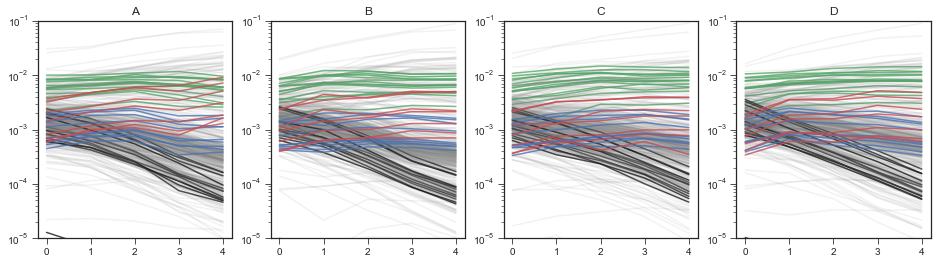

In [246]:
plt.figure(figsize=(4*4,4))
for r,rep in enumerate(reps):
    plt.subplot(1,4,r+1)
    plt.title(rep)
    timepoints = range(5)
    these_times = [f'{rep}{t}' for t in timepoints]
    print(rep)
    print(np.sum(data[these_times]))
    for bc in range(len(data['barcode'].values)):
        plotted = False
        for s,locs in enumerate(mutant_sets):
            if bc in locs:
                plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),mutant_colors[s],alpha=0.8)
                plotted = True
        if not plotted:
            plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),'gray',alpha=0.1)         
    plt.yscale('log')
    plt.ylim(10**-5,10**-1)
# plt.savefig('merged_trajectories_ABCD_setshighlighted.pdf',bbox_inches='tight')

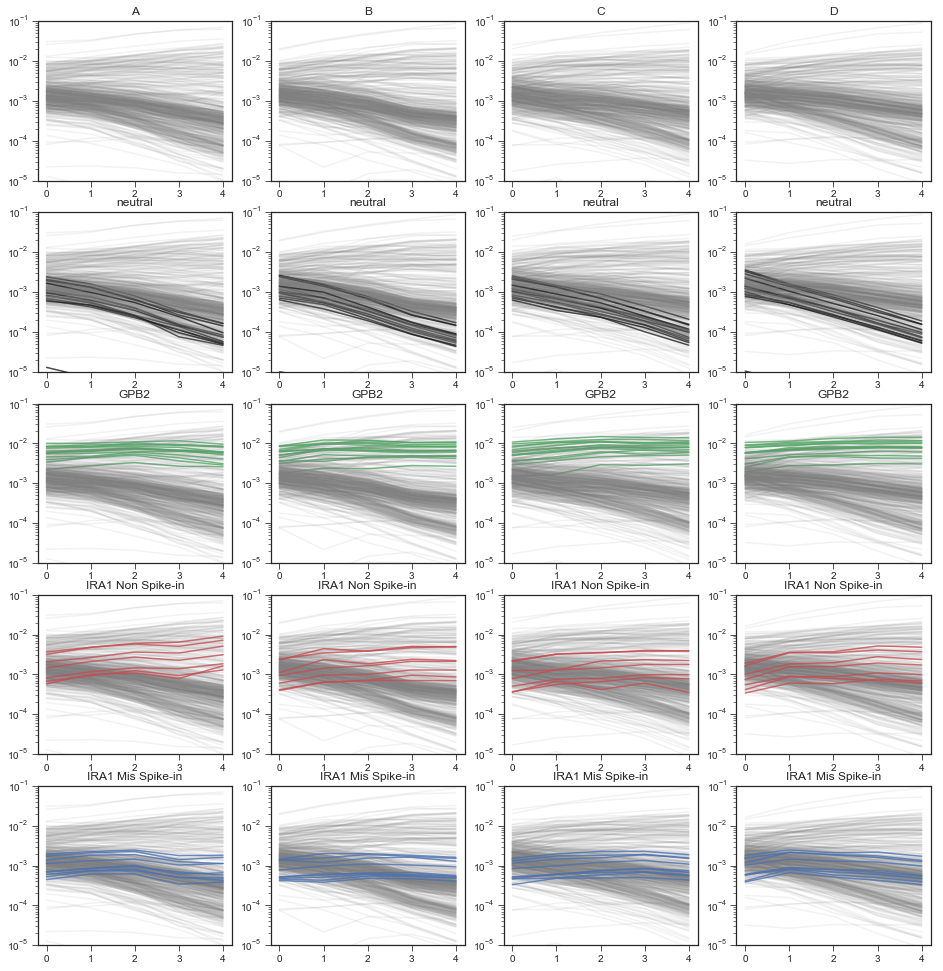

In [249]:
plt.figure(figsize=(4*len(reps),4*len(mutant_sets)+1))
for r,rep in enumerate(reps):
    
    plt.subplot(len(mutant_sets)+1,len(reps),r+1)
    plt.title(rep)
    timepoints = range(5)
    these_times = [f'{rep}{t}' for t in timepoints]
    
    
    for bc in range(len(data['barcode'].values)):
        plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),'gray',alpha=0.1) 
        
    plt.yscale('log')
    plt.ylim(10**-5,10**-1)
    
    for s,locs in enumerate(mutant_sets):
        plt.subplot(len(mutant_sets)+1,len(reps),(s+1)*len(mutant_sets)+r+1)
        plt.title(mutant_names[s])
        for bc in range(len(data['barcode'].values)):
            if bc in locs:
                plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),mutant_colors[s],alpha=0.8)
            else:
                plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),'gray',alpha=0.1) 
        plt.yscale('log')
        plt.ylim(10**-5,10**-1)
    
    
#     print(rep)
#     print(np.sum(data[these_times]))
#     for bc in range(len(data['barcode'].values)):
#         plotted = False
#         for s,locs in enumerate(mutant_sets):
            
#         if not plotted:
#             plt.plot(timepoints,data[these_times].values[bc,:]/np.sum(data[these_times]),'gray',alpha=0.1)         
    
plt.savefig('merged_trajectories_ABCD_by_set.pdf',bbox_inches='tight')

In [179]:
neutral_locs = np.where(np.isin(data['barcode'].values,neutrals))[0]
nonsense_locs = np.where(np.isin(data['barcode'].values,[9000101,9000104,9000105,9000106,9000107,9000109,9000110]))[0]
missense_locs = np.where(np.isin(data['barcode'].values,[9000000+bc for bc in range(11)]))[0]
gpb2_locs = np.where(np.isin(data['barcode'].values,data[data['gene'].isin(['GPB2'])]['barcode'].values))[0]

mutant_sets = [neutral_locs,gpb2_locs,nonsense_locs,missense_locs]
mutant_colors = ['gray','g','r','b']
mutant_names = ['neutral','GPB2','IRA1 Non Spike-in','IRA1 Mis Spike-in']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x115c395f8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x115c39780> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x115c39908> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <m

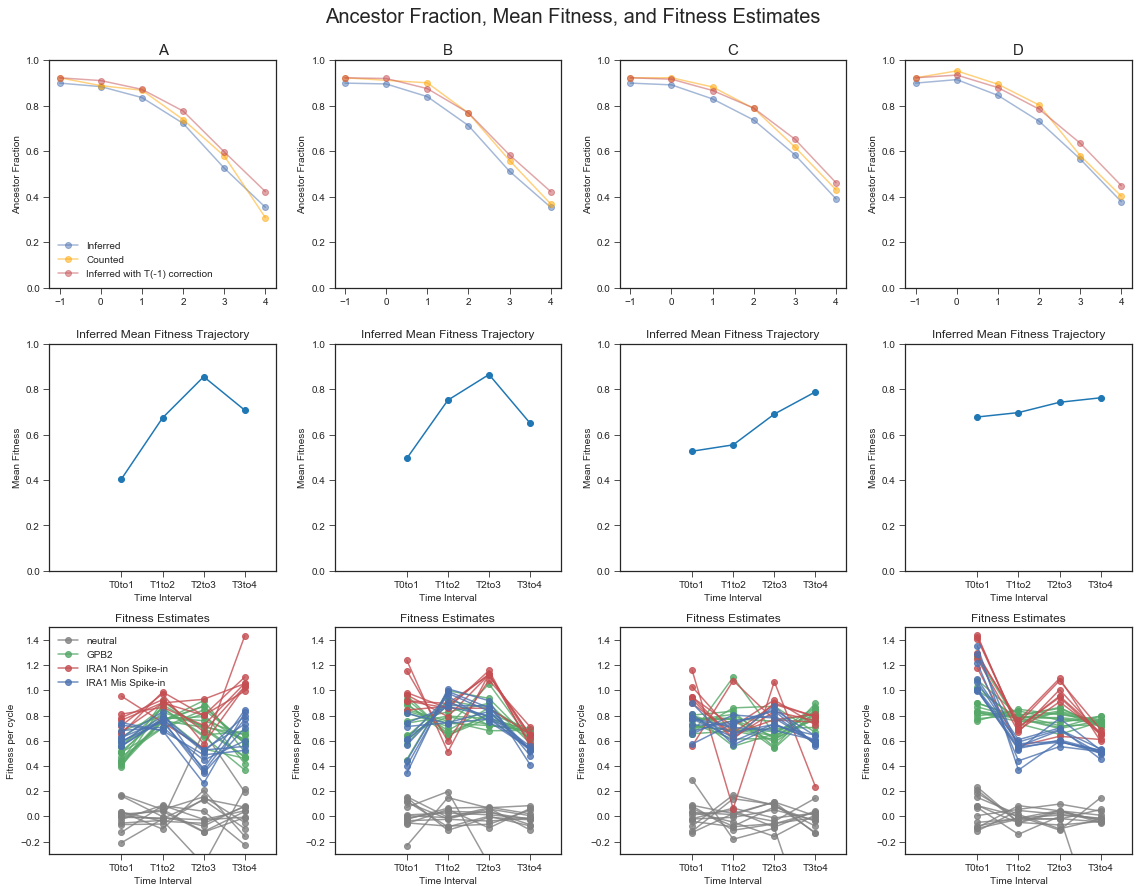

In [216]:
plt.figure(figsize=(len(reps)*4,3*4))
plt.suptitle('Ancestor Fraction, Mean Fitness, and Fitness Estimates',y=1.03,fontsize=20)

for r,rep in enumerate(reps):
    
    
    ### ANCESTOR FRACTION PLOTS
    plt.subplot(3,len(reps),r+1)
    plt.title(rep,fontsize=15)
    
    plt.plot([-1,0,1,2,3,4],[1-f for f in bc_fraction[rep]],'o-',color='b',alpha=0.5)
    plt.ylim(0,1)

    
    plt.plot(counted_anc_times[rep],counted_anc[rep],'o-',color='orange',alpha=0.5)
    
    plt.plot([-1,0,1,2,3,4],[1-f for f in bc_fraction_corrected[rep]],'o-',color='r',alpha=0.5)
    
    xmin,xmax = plt.xlim()
    if rep == reps[0]:
        plt.legend(['Inferred','Counted','Inferred with T(-1) correction'])
    plt.ylabel('Ancestor Fraction')
    
    
    ### INFERRED MEAN FITNESS TRAJECTORY
    plt.subplot(3,len(reps),len(reps)+r+1)
    plt.title('Inferred Mean Fitness Trajectory')
    
    plt.plot([i+0.5 for i in range(len(mean_fitness[rep]))],mean_fitness[rep],'o-')
    plt.ylim(0,1.0)
    plt.xlim(xmin,xmax)
    
    plt.xticks([i+0.5 for i in range(len(mean_fitness[rep]))],[f'T{i}to{i+1}' for i in range(len(mean_fitness[rep]))])
    plt.xlabel('Time Interval')
    plt.ylabel('Mean Fitness')
    
    
    
    
    ### FITNESS ESTIMATES
    plt.subplot(3,len(reps),2*len(reps)+r+1)
    plt.title('Fitness Estimates')
    
    this_f = fitness[rep].swapaxes(0,1)
    
    for m,mutants in enumerate(mutant_sets):
#         labels = [mutant_names[m]] + ["_nolegend_" for i in range(len(mutants))]
        plt.plot([i+0.5 for i in range(len(this_f[:,mutants]))],this_f[:,mutants],'o-',color=mutant_colors[m],alpha=0.8)
        
    plt.ylim(-0.3,1.5)
    plt.xlim(xmin,xmax)
    plt.ylabel('Fitness per cycle')
    
    plt.xticks([i+0.5 for i in range(len(this_f[:,mutants]))],[f'T{i}to{i+1}' for i in range(len(this_f[:,mutants]))])
    plt.xlabel('Time Interval')
    
    if rep == reps[0]:
        labels = []
        for m,mutants in enumerate(mutant_sets):
            labels = labels + [mutant_names[m]] + ["_nolegend_" for i in range(len(mutants))]
        plt.legend(labels)

plt.tight_layout()

plt.savefig('ancestorfrac_meanfitness_fitnessest.pdf',bbox_inches='tight')
    
  
    

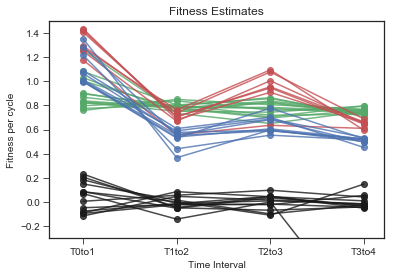

In [86]:
plt.title('Fitness Estimates')
    
this_f = fitness[rep].swapaxes(0,1)
this_var = counting_variance[rep].swapaxes(0,1)

for m,mutants in enumerate(mutant_sets):
#         labels = [mutant_names[m]] + ["_nolegend_" for i in range(len(mutants))]
    plt.plot([i+0.5 for i in range(len(this_f[:,mutants]))],this_f[:,mutants],'o-',color=mutant_colors[m],alpha=0.8)
#     plt.errorbar([i+0.5 for i in range(len(this_f[:,mutants]))],this_f[:,mutants],yerr=this_var[:,mutants],color=mutant_colors[m],alpha=0.8)


plt.ylim(-0.3,1.5)
plt.xlim(xmin,xmax)
plt.ylabel('Fitness per cycle')

plt.xticks([i+0.5 for i in range(len(this_f[:,mutants]))],[f'T{i}to{i+1}' for i in range(len(this_f[:,mutants]))])
plt.xlabel('Time Interval')
#     plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()

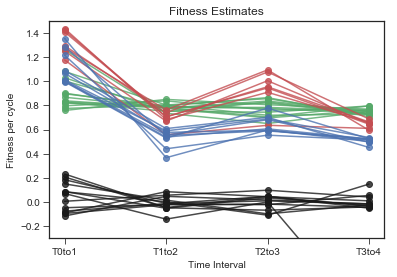

In [58]:
plt.title('Fitness Estimates')
    
this_f = fitness[rep].swapaxes(0,1)
this_var = counting_variance[rep].swapaxes(0,1)

for m,mutants in enumerate(mutant_sets):
    for loc in mutants:
#         labels = [mutant_names[m]] + ["_nolegend_" for i in range(len(mutants))]
#     plt.plot([i+0.5 for i in range(len(this_f[:,mutants]))],this_f[:,mutants],'o-',color=mutant_colors[m],alpha=0.8)
        plt.errorbar([i+0.5 for i in range(len(this_f[:,loc]))],this_f[:,loc],yerr=3*np.sqrt(this_var[:,loc]),marker='o',color=mutant_colors[m],alpha=0.8)

xmin, xmax = plt.xlim()
plt.ylim(-0.3,1.5)
plt.xlim(xmin,xmax)
plt.ylabel('Fitness per cycle')

plt.xticks([i+0.5 for i in range(len(this_f[:,mutants]))],[f'T{i}to{i+1}' for i in range(len(this_f[:,mutants]))])
plt.xlabel('Time Interval')
#     plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()

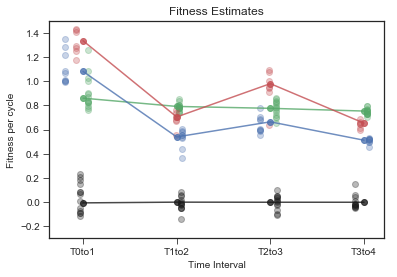

In [84]:
plt.title('Fitness Estimates')
    
this_f = fitness[rep].swapaxes(0,1)
this_var = counting_variance[rep].swapaxes(0,1)

for m,mutants in enumerate(mutant_sets):
    mean = np.nansum(this_f[:,mutants]/this_var[:,mutants],axis=1)/np.nansum(1/this_var[:,mutants],axis=1)
    var = 1/np.nansum(1/this_var[:,mutants],axis=1)
    

#         labels = [mutant_names[m]] + ["_nolegend_" for i in range(len(mutants))]
    plt.plot([tools.jitter_point(i,0.1)+0.5 for i in range(len(this_f[:,mutants]))],this_f[:,mutants],'o',color=mutant_colors[m],alpha=0.3)
    plt.errorbar([i+0.5 for i in range(len(this_f[:,mutants]))],mean,yerr=np.sqrt(var),marker='o',color=mutant_colors[m],alpha=0.8)

xmin, xmax = plt.xlim()
plt.ylim(-0.3,1.5)
plt.xlim(xmin,xmax)
plt.ylabel('Fitness per cycle')

plt.xticks([i+0.5 for i in range(len(this_f[:,mutants]))],[f'T{i}to{i+1}' for i in range(len(this_f[:,mutants]))])
plt.xlabel('Time Interval')
#     plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()

In [85]:
[tools.jitter_point(i,0.1)+0.5 for i in range(len(this_f[:,mutants]))]

[0.367596304181828, 1.6596941753017438, 2.426637425910627, 3.3072362570221703]

In [145]:
# data
no_digest_conditions = ['A0-DE2-PCRa',
'A4-DE1-PCRb',
'B2-DE1-PCRc',
'C0-DE1-PCRc',
'D1-DE1-PCRb',
'E0-DE2-PCRa',
'E4-DE1-PCRb',
'F3-DE1-PCRb',
'A1-DE1-PCRb',
'B3-DE1-PCRc',
# 'C2-DE3-PCRb', # this is a 27 cycle bubble product sample
'D2-DE1-PCRb',
'E1-DE2-PCRa',
'F0-DE2-PCRa',
'F4-DE1-PCRb',
'Tneg-DE3-PCRa',
'A2-DE1-PCRb',
'B1-DE2-PCRa',
'B4-DE5-PCRa',
'C2-DE3-PCRa',
'C3-DE2-PCRa',
'D3-DE1-PCRb',
'E2-DE1-PCRb',
'F1-DE1-PCRb',
'A3-DE1-PCRb',
'C1-DE1-PCRc',
'C4-DE3-PCRa',
# 'C4-DE3-PCRb', # this is a 27 cycle bubble product sample
'D0-DE2-PCRa',
'D4-DE1-PCRb',
'E3-DE1-PCRb',
'F2-DE1-PCRb']

anc_data = unmerged_data
anc_data = anc_data.replace([np.inf, -np.inf], np.nan)
anc_data = anc_data.sort_values('barcode')

counted_anc = {}
counted_anc_times = {}

for rep in reps:
    
    timepoints = range(5)
    accepted_times = []
    for t in timepoints:
        for col in no_digest_conditions:
            if col.split('-')[0] == f'{rep}{t}':
                accepted_times.append(t)

    these_times = ['Tneg-DE3-PCRa'] + [col for t in timepoints for col in no_digest_conditions if col.split('-')[0] == f'{rep}{t}']
    
    
    
    these_counts = anc_data[these_times].values
    these_freqs = these_counts/np.sum(these_counts,axis=0)
#     print(len(these_freqs[-1,:]))
#     print(len(accepted_times))
    
    counted_anc[rep] = these_freqs[-1,:]
    counted_anc_times[rep] = [-1]+accepted_times
    
    print(len(counted_anc[rep] ))
    print(len(counted_anc_times[rep] ))

6
6
5
5
6
6
6
6


In [146]:
counted_anc_times[rep]


[-1, 0, 1, 2, 3, 4]

In [141]:
counted_anc[rep] 

array([0.92333851, 0.95377224, 0.8950107 , 0.8037395 , 0.5808648 ,
       0.40214569])

In [62]:
this_data = data[these_times].values
np.sum(this_data[neutral_locs,:],axis=0)/np.sum(this_data)

array([0.00172584, 0.00235888, 0.00086452, 0.00061689, 0.00033125])

In [58]:
np.sum(this_data[neutral_locs,:])

103313.0

In [61]:
np.sum(this_data[neutral_locs,:],axis=0)

array([30234., 41324., 15145., 10807.,  5803.])

In [114]:
np.asarray([[x,y] for x,y in counted_anc['A']])

array([], dtype=float64)

In [115]:
[[x,y] for x,y in counted_anc['A']]

[]

In [128]:
this.swapaxes(0,1)

array([[0.        , 1.        , 2.        , 3.        , 4.        ],
       [0.92333851, 0.88881898, 0.86849765, 0.73934009, 0.57899267]])

In [131]:
counted_anc_frac

[]

In [252]:
unmerged_data

,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,...,Z2-DE2-PCRa,Z3-DE1-PCRa,Z4-DE1-PCRa,Z4-DE2-PCRa,barcode,gene,type,ploidy,class,additional_muts
0,2,10,512,700,594,594,403,104,319,299,...,101,15,66,62,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...
1,2625,3914,43106,54385,42068,160273,107883,20536,399304,308884,...,25656,3506,95528,88658,151,IRA1,stop_gained,Haploid,PKA,SEH1-missense_variant; ZIP1-missense_variant; ...
2,15,46,2909,2977,2776,2582,1640,442,1524,1028,...,25,6,57,54,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
3,710,1187,36510,32361,30864,92924,59293,14493,149876,114393,...,9232,935,13589,12861,273,IRA1,frameshift_variant,Haploid,PKA,None
4,373,631,21956,23483,22294,46277,33707,7626,79897,57846,...,1298,163,3420,3339,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
5,88,165,2745,4386,3120,7695,7096,1194,17769,18873,...,11098,1540,19546,17268,415,IRA1,frameshift_variant,Haploid,PKA,None
6,48,104,2335,3792,3057,5985,5549,1073,10823,10856,...,0,0,0,0,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
7,0,3,64,57,65,81,27,7,34,23,...,45,9,43,38,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
8,170,278,5462,7846,6551,15647,11789,1937,28198,27943,...,4095,646,7829,6926,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant
9,6,5,937,1094,910,936,601,141,581,397,...,83,5,55,41,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced


In [258]:
unmerged_data[~unmerged_data['barcode'].isin([9999999])]

,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,...,Z2-DE2-PCRa,Z3-DE1-PCRa,Z4-DE1-PCRa,Z4-DE2-PCRa,barcode,gene,type,ploidy,class,additional_muts
0,2,10,512,700,594,594,403,104,319,299,...,101,15,66,62,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...
1,2625,3914,43106,54385,42068,160273,107883,20536,399304,308884,...,25656,3506,95528,88658,151,IRA1,stop_gained,Haploid,PKA,SEH1-missense_variant; ZIP1-missense_variant; ...
2,15,46,2909,2977,2776,2582,1640,442,1524,1028,...,25,6,57,54,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
3,710,1187,36510,32361,30864,92924,59293,14493,149876,114393,...,9232,935,13589,12861,273,IRA1,frameshift_variant,Haploid,PKA,None
4,373,631,21956,23483,22294,46277,33707,7626,79897,57846,...,1298,163,3420,3339,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
5,88,165,2745,4386,3120,7695,7096,1194,17769,18873,...,11098,1540,19546,17268,415,IRA1,frameshift_variant,Haploid,PKA,None
6,48,104,2335,3792,3057,5985,5549,1073,10823,10856,...,0,0,0,0,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
7,0,3,64,57,65,81,27,7,34,23,...,45,9,43,38,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced
8,170,278,5462,7846,6551,15647,11789,1937,28198,27943,...,4095,646,7829,6926,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant
9,6,5,937,1094,910,936,601,141,581,397,...,83,5,55,41,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced


In [259]:
np.max(unmerged_data[~unmerged_data['barcode'].isin([9999999])])

13-0                                                            2625
13-0_pool                                                       4607
13-1-1                                                         62196
13-1-2                                                         82157
13-1-3                                                         66626
13-2-1                                                        206547
13-2-2                                                        148874
13-2-3                                                         29886
13-3-1                                                        441643
13-3-2                                                        387681
13-3-3                                                        361140
13-4-1                                                        223043
13-4-2                                                        242659
13-4-3                                                        159648
18-1-1                            

In [63]:
mean = np.nansum(this_f/this_var,axis=0)/np.nansum(1/this_var,axis=0)
var = 1//np.nansum(1/this_var,axis=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 4.34415557e-01,  1.07563359e+00,  4.30031760e-01,  8.97875516e-01,
        7.59354306e-01,  9.58858622e-01,            -inf,  4.16062447e-01,
        1.04395738e+00,  3.82248551e-01,            -inf,             nan,
        9.67400149e-01,  1.00466088e+00,  4.09750847e-01,  7.73735148e-01,
        3.95555830e-02,  2.76622190e-02,  7.62649677e-01,  4.47916549e-01,
        5.58196029e-01,  7.78341381e-01,  7.81281978e-01,  5.15895826e-01,
        7.67584302e-01,  4.10059921e-01,  5.75479992e-01,            -inf,
        4.37711901e-01,            -inf,  4.18845089e-01,  7.90201523e-01,
        6.11268967e-01,  3.14542759e-01,  4.08535319e-01,  9.02726775e-01,
        1.09097572e+00,  3.58119062e-01,  4.30428076e-01,  3.94188036e-01,
        6.01446736e-01,  8.69914421e-01,  8.61538799e-01,  4.16209931e-01,
        7.33914006e-01,             nan,  8.59791357e-01,  7.47383668e-01,
        5.98144005e-01,  6.58487345e-01,             nan,  4.05578041e-01,
        6.35247653e-01, -

In [68]:
mean = np.nansum(this_f[:,mutants]/this_var[:,mutants],axis=1)/np.nansum(1/this_var[:,mutants],axis=1)
var = 1/np.nansum(1/this_var[:,mutants],axis=1)


In [69]:
vars

array([6.54806931e-08, 1.04839150e-08, 1.90280268e-08, 1.14809850e-08])

In [70]:
means

array([1.08177799, 0.53928622, 0.66415199, 0.51192943])

In [71]:
this_var[:,mutants]

array([[1.29237061e-06, 4.53728712e-07, 2.94725339e-07, 3.43715589e-07,
        9.23121867e-07, 9.07988721e-07, 1.37000418e-06, 8.79163683e-07,
        5.15573383e-07],
       [1.58963641e-07, 5.96913176e-08, 5.18388112e-08, 5.99680934e-08,
        1.47915435e-07, 1.58963641e-07, 1.93327571e-07, 1.44153082e-07,
        8.91781530e-08],
       [3.43207125e-07, 1.07148524e-07, 9.50898949e-08, 1.07268199e-07,
        2.50977684e-07, 2.89279500e-07, 3.87782479e-07, 2.52406817e-07,
        1.54158578e-07],
       [2.22101132e-07, 6.98701840e-08, 5.13594116e-08, 6.37672599e-08,
        1.46274837e-07, 1.85453593e-07, 2.61946917e-07, 1.63716823e-07,
        9.10840676e-08]])